# Importações

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from constants import DIR_OUTPUT_TABLES, DIR_OUTPUT_GRAPHS, DIR_OTHERS_DATA

# Carregando arquivos csv

## Tabela relacionando Games vs. Adaptações
(output de game_adaptation.ipynb)

In [2]:
df_game_adaptation = pd.read_csv(os.path.join(DIR_OUTPUT_TABLES, 'game_adaptation.csv'),)
df_game_adaptation['ReleaseDate'] = pd.to_datetime(df_game_adaptation['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.date
df_game_adaptation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GameTitle                              86 non-null     object 
 1   MaxHistoricalPeak                      86 non-null     int64  
 2   AdaptReleasePeak                       86 non-null     int64  
 3   AdaptReleaseAbsoluteGrowth             86 non-null     float64
 4   AdaptReleasePercentualGrowth           86 non-null     float64
 5   PreviousYearPeak                       82 non-null     float64
 6   PreviousYearAbsoluteGrowth             81 non-null     float64
 7   PreviousYearPercentualGrowth           81 non-null     float64
 8   NextMonthPeak                          85 non-null     float64
 9   NextMonthAbsoluteGrowth                85 non-null     float64
 10  NextMonthPercentualGrowth              85 non-null     float64
 11  NextMont

## Tabela relacionando Games vs. Adaptações
(somente jogos com crescimentos estatisticamente significativos, segundo MannWhitney)

In [3]:
stat_relevant = pd.read_csv(os.path.join(DIR_OTHERS_DATA, 'estat_relevantes.csv'),)
df_game_adaptation_relevant = df_game_adaptation[df_game_adaptation['GameTitle'].isin(stat_relevant['gameTitle'])].copy()
df_game_adaptation_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 5 to 82
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GameTitle                              25 non-null     object 
 1   MaxHistoricalPeak                      25 non-null     int64  
 2   AdaptReleasePeak                       25 non-null     int64  
 3   AdaptReleaseAbsoluteGrowth             25 non-null     float64
 4   AdaptReleasePercentualGrowth           25 non-null     float64
 5   PreviousYearPeak                       24 non-null     float64
 6   PreviousYearAbsoluteGrowth             24 non-null     float64
 7   PreviousYearPercentualGrowth           24 non-null     float64
 8   NextMonthPeak                          25 non-null     float64
 9   NextMonthAbsoluteGrowth                25 non-null     float64
 10  NextMonthPercentualGrowth              25 non-null     float64
 11  NextMonthPrev

# Análise dos dados

## Percentual máximo do crescimento por jogo

### Função para adicionar nova coluna HistoricalPeakRatio

In [7]:
def add_percentual_growth(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adiciona a coluna de crescimento percentual de jogadores.
    """
    # Calcula a razão AdaptReleasePeak / MaxHistoricalPeak e adiciona a coluna HistoricalPeakRatio
    df['HistoricalPeakRatio'] = (
        (df['AdaptReleasePeak'] / df['MaxHistoricalPeak'])*100
    )
    return df

df_game_adaptation = add_percentual_growth(df_game_adaptation)
df_game_adaptation_relevant = add_percentual_growth(df_game_adaptation_relevant)
df_game_adaptation['HistoricalPeakRatio'].describe()

count     86.000000
mean      39.742986
std       53.677892
min        1.943162
25%        7.874186
50%       20.204436
75%       51.619331
max      350.914634
Name: HistoricalPeakRatio, dtype: float64

### Função para plotar barplot com o HistoricalPeakRatio de cada jogo

In [50]:
def barplot_percentMaxGrowth(
    base_df: pd.DataFrame, 
    graph_title: str, 
    output_file: str,
    adaptation_type: str | None = None,
    ylabel_size: int = 6,
    only_greater_than_100: bool = False
) -> None:
    
    hue = 'Type'
    
    if only_greater_than_100:
        df = base_df[base_df['HistoricalPeakRatio'] > 100.0].copy()
    else:
        df = base_df.copy()
        
    if adaptation_type:
        df = df[df['Type'] == adaptation_type].copy()
        hue = None  # Não colore por tipo se for um tipo específico
        
    # agrega o valor máximo por jogo
    # max_growth = (
    #     df
    #     .groupby('GameTitle')['HistoricalPeakRatio']
    #     .max()
    #     .reset_index()
    #     .sort_values('HistoricalPeakRatio', ascending=False)
    # )
    max_idx = df.groupby('GameTitle')['HistoricalPeakRatio'].idxmax()
    max_growth = (
        df.loc[max_idx, ['GameTitle', 'HistoricalPeakRatio', 'Type']]
        .sort_values('HistoricalPeakRatio', ascending=False)
    )

    plt.figure(figsize=(10,8))
    ax = sns.barplot(
        y='GameTitle',
        x='HistoricalPeakRatio',
        data=max_growth,
        hue=hue,  # colore por tipo da adaptação
        palette='viridis'
    )
    plt.xlabel('Crescimento relativo ao pico histórico (%)')
    plt.ylabel('Jogo')
    plt.title(graph_title)

    # reduz o tamanho da fonte dos rótulos de y
    ax.tick_params(axis='y', labelsize=ylabel_size)

    # adiciona linha vertical em x=1.0
    ax.axvline(x=100.0, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    
    # Salvar gráfico em arquivo
    # output_path = os.path.join(DIR_OUTPUT_GRAPHS, output_file)
    # plt.savefig(
    #     output_path, 
    #     dpi=300, 
    #     bbox_inches='tight'
    # )
    
    plt.show()

In [51]:
def barplot_percentMaxGrowth_color_graded(
    base_df: pd.DataFrame, 
    graph_title: str, 
    output_file: str,
    adaptation_type: str | None = None,
    ylabel_size: int = 6,
    only_greater_than_100: bool = False
) -> None:
    
    hue = 'Type'
    
    if only_greater_than_100:
        df = base_df[base_df['HistoricalPeakRatio'] > 100.0].copy()
    else:
        df = base_df.copy()
        
    if adaptation_type:
        df = df[df['Type'] == adaptation_type].copy()
        hue = None  # Não colore por tipo se for um tipo específico
        
    max_idx = df.groupby('GameTitle')['HistoricalPeakRatio'].idxmax()
    max_growth = (
        df.loc[max_idx, ['GameTitle','HistoricalPeakRatio','Type']]
        .sort_values('HistoricalPeakRatio', ascending=False)
    )

    # calcula gradiente de cor por Type
    type_cmaps = {'Movie': plt.cm.Reds, 'Show': plt.cm.Blues}
    # extrai mínimo e máximo de HistoricalPeakRatio por Type
    type_ranges = {
        t: (grp.min(), grp.max())
        for t, grp in max_growth.groupby('Type')['HistoricalPeakRatio']
    }

    # normaliza e “levanta” o gradiente para [0.3,1.0]
    bar_colors = []
    for _, row in max_growth.iterrows():
        vmin, vmax = type_ranges[row.Type]
        norm_val = (row.HistoricalPeakRatio - vmin) / (vmax - vmin + 1e-9)
        shade = 0.2 + 0.7 * norm_val
        bar_colors.append(type_cmaps[row.Type](shade))

    plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.barh(
        max_growth['GameTitle'],
        max_growth['HistoricalPeakRatio'],
        color=bar_colors
    )

    # inverte o eixo y para que as maiores barras fiquem no topo
    ax.invert_yaxis()

    plt.xlabel('Crescimento relativo ao pico histórico (%)')
    plt.ylabel('Jogo')
    plt.title(graph_title)
    ax.tick_params(axis='y', labelsize=ylabel_size)
    ax.axvline(x=100.0, color='red', linestyle='--', linewidth=1)
    plt.tight_layout()
    
    # Salvar gráfico em arquivo
    output_path = os.path.join(DIR_OUTPUT_GRAPHS, output_file)
    plt.savefig(
        output_path, 
        dpi=300, 
        bbox_inches='tight'
    )
    
    plt.show()

### Barplot (todos os jogos)

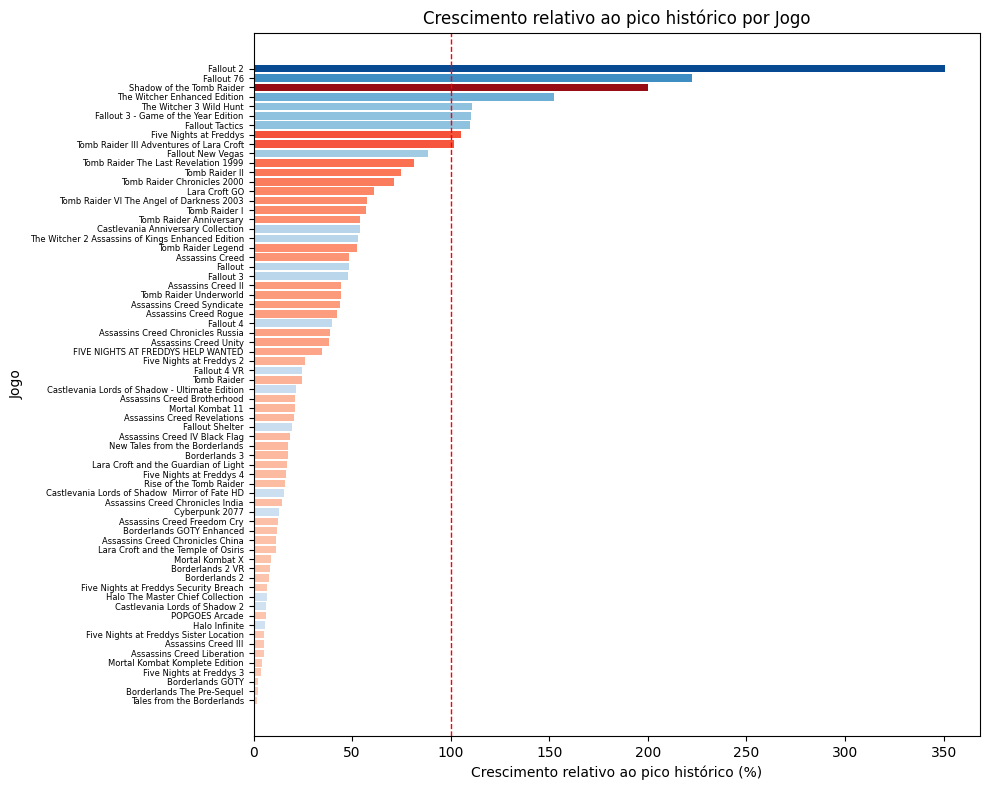

In [52]:
barplot_percentMaxGrowth_color_graded(
    df_game_adaptation,
    graph_title='Crescimento relativo ao pico histórico por Jogo',
    output_file='barplot_historicalPeakRatio_todos.png',
    ylabel_size=6,
    only_greater_than_100=False
)

### Barplot (somente jogos com adaptações em filmes)

/tmp/ipykernel_1979/3014526098.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


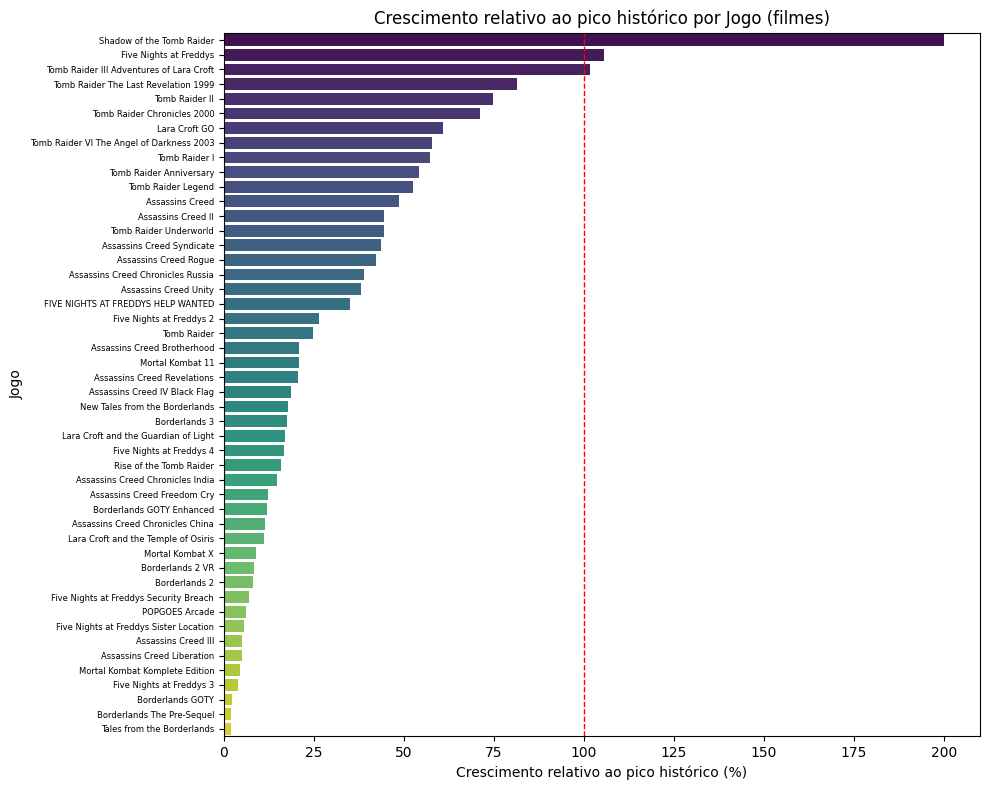

In [53]:
barplot_percentMaxGrowth(
    df_game_adaptation,
    graph_title='Crescimento relativo ao pico histórico por Jogo (filmes)',
    output_file='barplot_historicalPeakRatio_filmes.png',
    adaptation_type='Movie',
    only_greater_than_100=False
)

### Barplot (somente jogos com adaptações em séries de TV)

/tmp/ipykernel_1979/3014526098.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


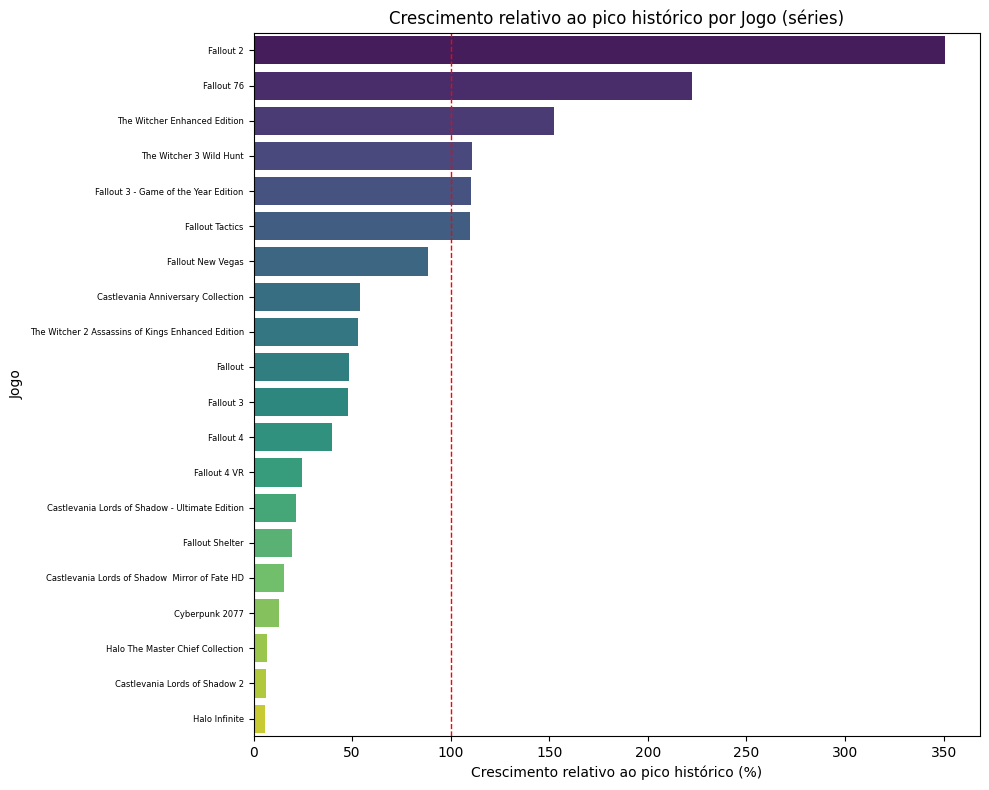

In [54]:
barplot_percentMaxGrowth(
    df_game_adaptation,
    graph_title='Crescimento relativo ao pico histórico por Jogo (séries)',
    output_file='barplot_historicalPeakRatio_seriesTV.png',
    adaptation_type='Show',
    only_greater_than_100=False
)

### Barplot (somente jogos com crescimento maior que 100%)

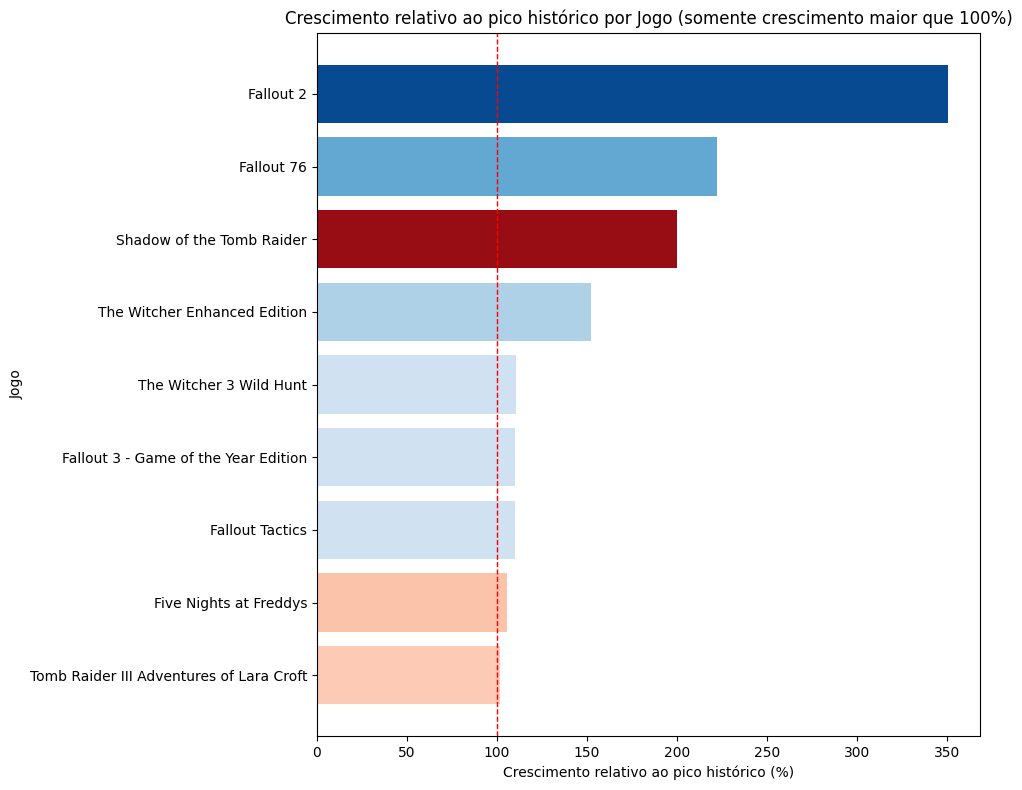

In [55]:
barplot_percentMaxGrowth_color_graded(
    df_game_adaptation,
    graph_title='Crescimento relativo ao pico histórico por Jogo (somente crescimento maior que 100%)',
    output_file='barplot_historicalPeakRatio_maiorQue100.png',
    ylabel_size=10,
    only_greater_than_100=True
)

### Barplot (somente jogos com crescimentos estatisticamente significativos)
segundo MannWhitney

/tmp/ipykernel_1979/1913950865.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


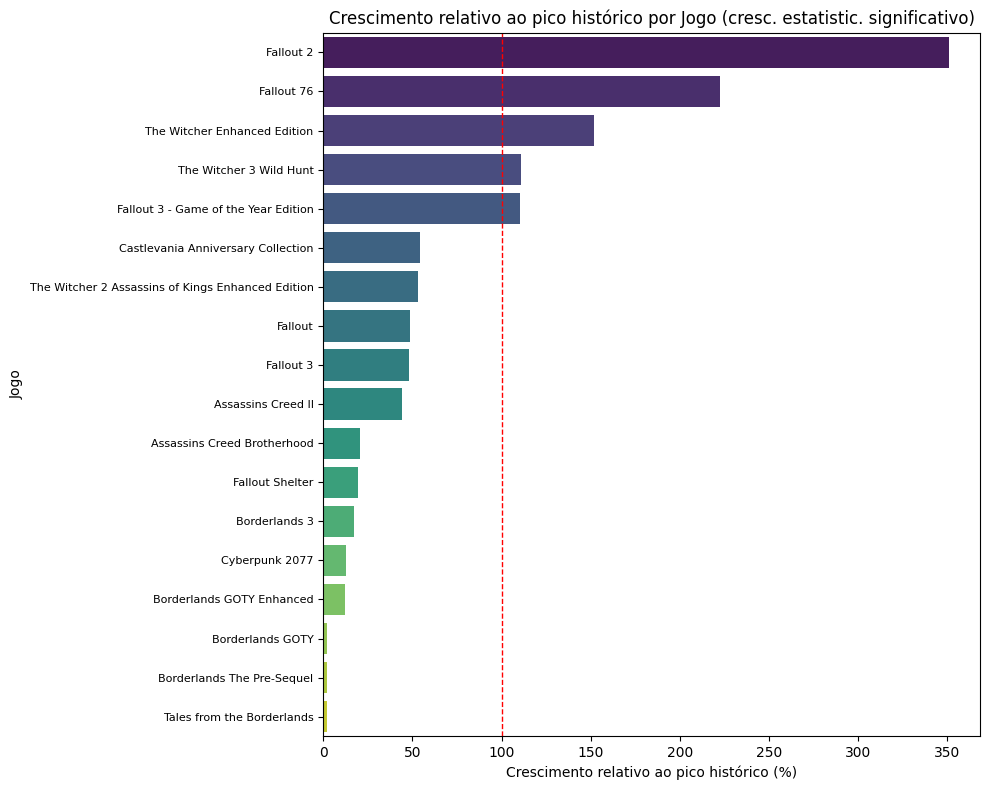

In [ ]:
barplot_percentMaxGrowth_color_graded(
    df_game_adaptation_relevant,
    graph_title='Crescimento relativo ao pico histórico por Jogo (cresc. estatistic. significativo)',
    output_file='barplot_historicalPeakRatio_jogosSignificativos.png',
    ylabel_size=8,
    only_greater_than_100=False
)

## Crescimento percentual no lançamento da adaptação

### Função para plotar barplot com o AdaptReleasePercentualGrowth de cada jogo

In [16]:
def barplot_adaptReleasePercentualGrowth(
    initial_df: pd.DataFrame, 
    graph_title: str, 
    output_file: str, 
    ylabel_size: int = 6,
    only_greater_than_100: bool = False
) -> None:
    
    if only_greater_than_100:
        df = initial_df[initial_df['AdaptReleasePercentualGrowth'] > 100.0].copy()
        graph_title += ' (somente crescimento maior que 100%)'
    else:
        df = initial_df.copy()
        
    # agrega o valor máximo por jogo
    max_growth = (
        df
        .groupby('GameTitle')['AdaptReleasePercentualGrowth']
        .max()
        .reset_index()
        .sort_values('AdaptReleasePercentualGrowth', ascending=False)
    )

    plt.figure(figsize=(10,8))
    ax = sns.barplot(
        y='GameTitle',
        x='AdaptReleasePercentualGrowth',
        data=max_growth,
        palette='viridis'
    )
    plt.xlabel('Crescimento percentual no lançamento da adaptação.')
    plt.ylabel('Jogo')
    plt.title(graph_title)

    # reduz o tamanho da fonte dos rótulos de y
    ax.tick_params(axis='y', labelsize=ylabel_size)

    # adiciona linha vertical em x=1.0
    ax.axvline(x=100.0, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    
    # Salvar gráfico em arquivo
    output_path = os.path.join(DIR_OUTPUT_GRAPHS, output_file)
    plt.savefig(
        output_path, 
        dpi=300, 
        bbox_inches='tight')
    
    plt.show()

### Barplot (todos os jogos)

/tmp/ipykernel_1979/2729869367.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


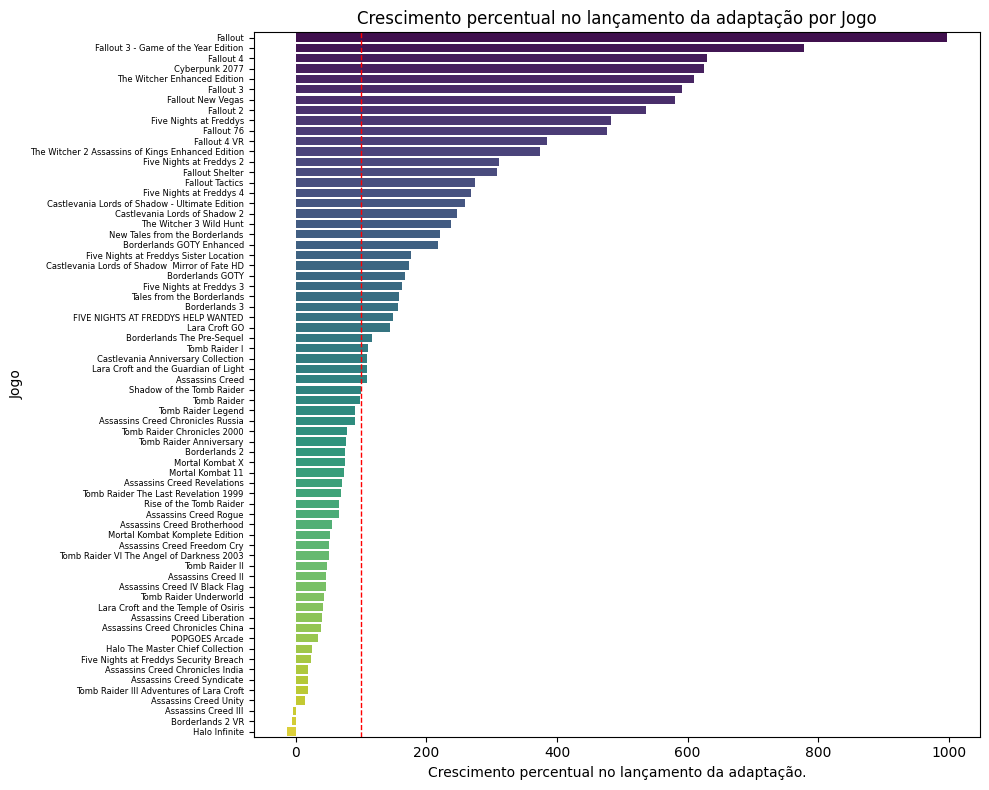

In [17]:
barplot_adaptReleasePercentualGrowth(
    df_game_adaptation,
    "Crescimento percentual no lançamento da adaptação por Jogo",
    'barplot_adaptReleasePercentualGrowth_todos.png',
    only_greater_than_100=False
)

### Barplot (somente jogos com crescimento maior que 100%)

/tmp/ipykernel_1979/2729869367.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


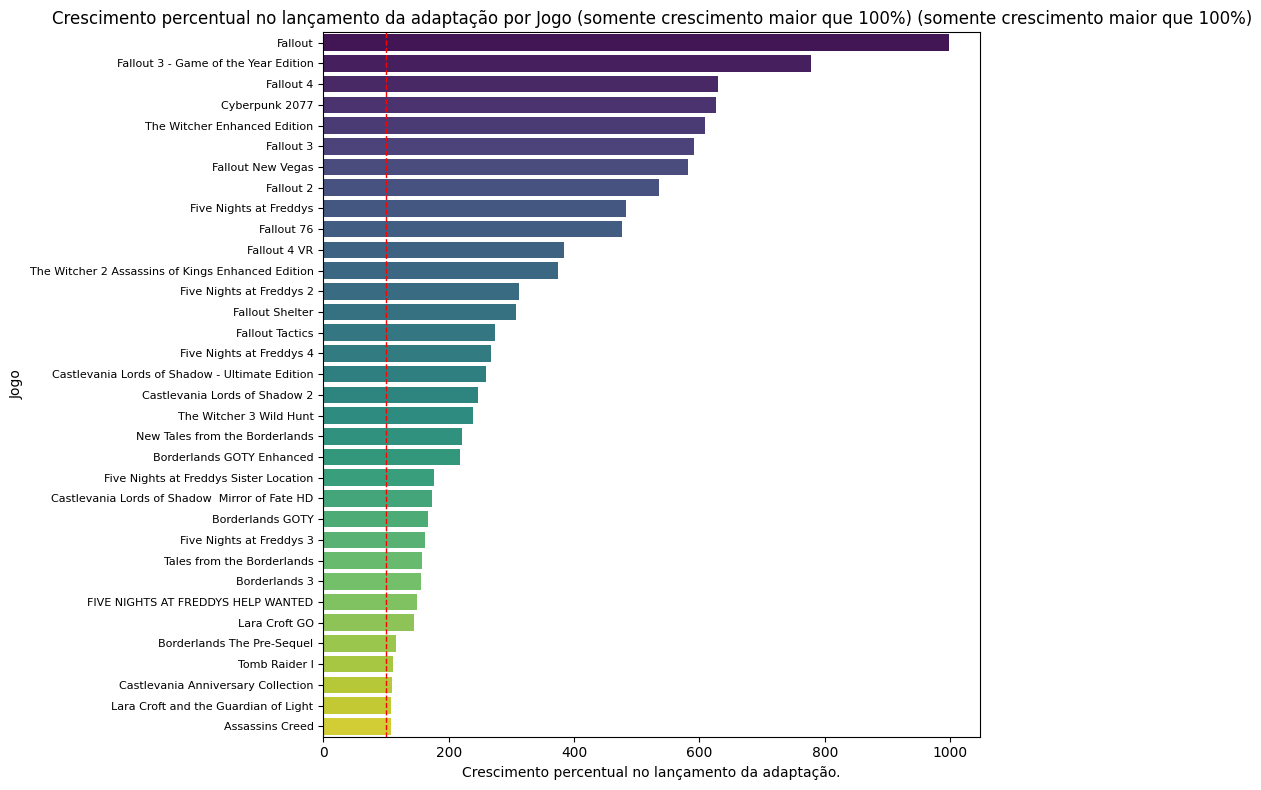

In [21]:
barplot_adaptReleasePercentualGrowth(
    df_game_adaptation,
    "Crescimento percentual no lançamento da adaptação por Jogo (somente crescimento maior que 100%)",
    'barplot_adaptReleasePercentualGrowth_maiorQue100.png',
    ylabel_size=8,
    only_greater_than_100=True
)

### Barplot (somente jogos com crescimentos estatisticamente significativos)
segundo MannWhitney

/tmp/ipykernel_1979/2729869367.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


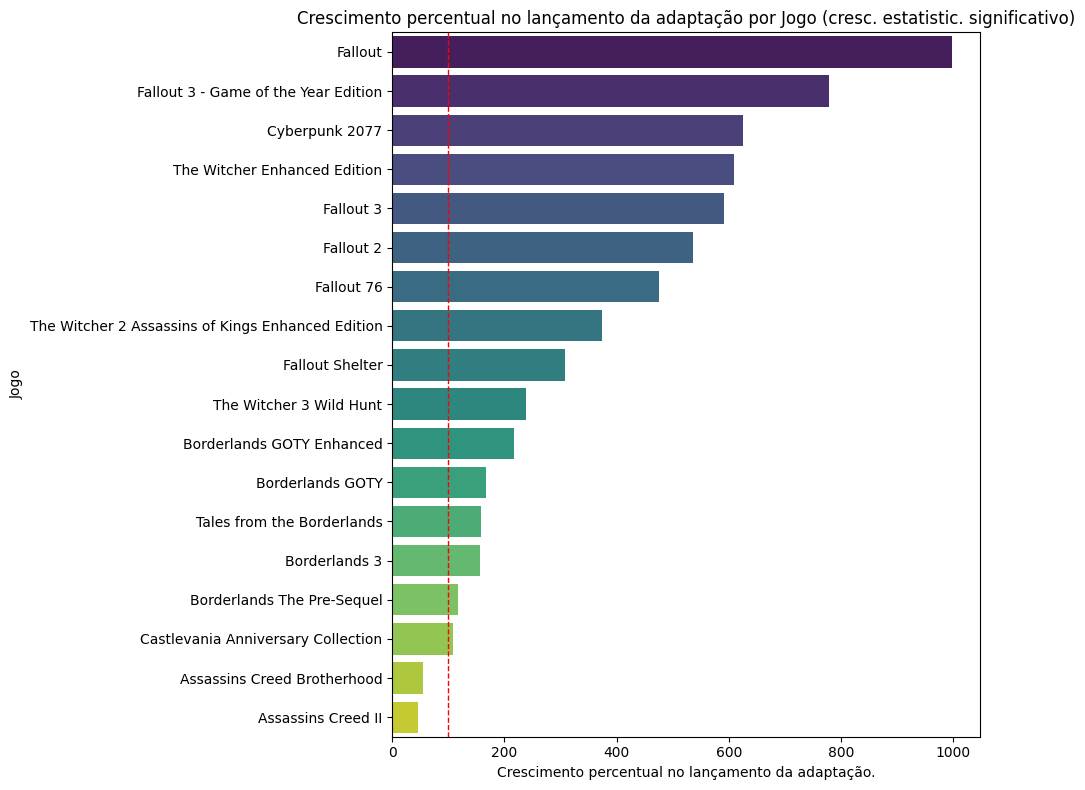

In [24]:
barplot_adaptReleasePercentualGrowth(
    df_game_adaptation_relevant,
    "Crescimento percentual no lançamento da adaptação por Jogo (cresc. estatistic. significativo)",
    'barplot_adaptReleasePercentualGrowth_jogosSignificativos.png',
    ylabel_size=10,
    only_greater_than_100=False
)